[Source](https://gist.github.com/jfpuget/60e07a82dece69b011bb)  https://gist.github.com/jfpuget/60e07a82dece69b011bb

# How To Quickly Compute The Mandelbrot Set In Python

## An experiment with parallelism and gpu computing using Numpy, Numexpr, Numba, Cython, PyOpenGL, and PyCUDA.

## Author: [Jean-François Puget](https://www.ibm.com/developerworks/community/blogs/jfp?lang=en)

Motivation and explanation for the code is available at [How To Quickly Compute The Mandelbrot Set In Python](https://www.ibm.com/developerworks/community/blogs/jfp/entry/How_To_Compute_Mandelbrodt_Set_Quickly?lang=en)

Timings depend heavily on the machine and Python version used.  The timings below are for a Windows laptop (Lenovo Thinkpad W520) with Anaconda 64 bits and Python 3.5.  A more recent machine could be way faster for gpu computing for instance.

Let's import some useful packages first.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
%matplotlib inline

# Display

In order to check code correctness we will display the images.  

The display code is taken from [How To Make Python Run As Fast As Julia.](https://www.ibm.com/developerworks/community/blogs/jfp/entry/Python_Meets_Julia_Micro_Performance?lang=en)

We use small image sizes to enable quick check on all code, including the slowest ones.

Square view is used (size):
* width=height=length
* origin at left lower corner: xmin=x0, xmax = x0 + size, ymin=y0, ymax = y0 + size 

In [2]:
def mandelbrot_image(xmin,xmax,ymin,ymax,width=3,height=3,maxiter=80,cmap='hot'):
    """
    Args:
        xmin,xmax,ymin,ymax: bounding box coordinates
        width/height: image dimensions in inch
        maxiter: max of iterations
    """
    dpi = 72  # image resolution - dots per inch
    img_width = dpi * width
    img_height = dpi * height
    x,y,z = mandelbrot_set(xmin,xmax,ymin,ymax,img_width,img_height,maxiter)
    
    fig, ax = plt.subplots(figsize=(width, height),dpi=dpi)
    ticks = np.arange(0,img_width,3*dpi)
    x_ticks = xmin + (xmax-xmin)*ticks/img_width
    plt.xticks(ticks, x_ticks)
    y_ticks = ymin + (ymax-ymin)*ticks/img_width
    plt.yticks(ticks, y_ticks)
    
    norm = colors.PowerNorm(0.3)
    ax.imshow(z.T,cmap=cmap,origin='lower',norm=norm) 

In [3]:
mandelbrot_image

<function __main__.mandelbrot_image(xmin, xmax, ymin, ymax, width=3, height=3, maxiter=80, cmap='hot')>

## Baseline

Let's set a base line, using code from [Julia GitHhub](https://github.com/JuliaLang/julia/blob/master/test/perf/micro/perf.py)

In [4]:
def mandelbrot(c,maxiter):
    z = c
    for n in range(maxiter):
        if (z.real * z.real + z.imag * z.imag) > 4:
            return n
        z = z*z + c
    return 0

def mandelbrot_set(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)
    n3 = np.empty((width,height))
    for i in range(width):
        for j in range(height):
            n3[i,j] = mandelbrot(r1[i] + 1j*r2[j],maxiter)
    return (r1,r2,n3)

We use two images for the benchmark

In [5]:
%time mandelbrot_set(-2.0,0.5,-1.25,1.25,1000,1000,80)

Wall time: 18.3 s


(array([-2.00000000e+00, -1.99749750e+00, -1.99499499e+00, -1.99249249e+00,
        -1.98998999e+00, -1.98748749e+00, -1.98498498e+00, -1.98248248e+00,
        -1.97997998e+00, -1.97747748e+00, -1.97497497e+00, -1.97247247e+00,
        -1.96996997e+00, -1.96746747e+00, -1.96496496e+00, -1.96246246e+00,
        -1.95995996e+00, -1.95745746e+00, -1.95495495e+00, -1.95245245e+00,
        -1.94994995e+00, -1.94744745e+00, -1.94494494e+00, -1.94244244e+00,
        -1.93993994e+00, -1.93743744e+00, -1.93493493e+00, -1.93243243e+00,
        -1.92992993e+00, -1.92742743e+00, -1.92492492e+00, -1.92242242e+00,
        -1.91991992e+00, -1.91741742e+00, -1.91491491e+00, -1.91241241e+00,
        -1.90990991e+00, -1.90740741e+00, -1.90490490e+00, -1.90240240e+00,
        -1.89989990e+00, -1.89739740e+00, -1.89489489e+00, -1.89239239e+00,
        -1.88988989e+00, -1.88738739e+00, -1.88488488e+00, -1.88238238e+00,
        -1.87987988e+00, -1.87737738e+00, -1.87487487e+00, -1.87237237e+00,
        -1.8

Wall time: 876 ms


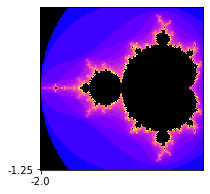

In [5]:
%time mandelbrot_image(-2.0,0.5,-1.25,1.25, maxiter=80,cmap='gnuplot2')

# Numpy

Let's replace lists with Numpy arrays.

In [18]:
def mandelbrot(c,maxiter):
    z = c
    for n in range(maxiter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return 0

def mandelbrot_set(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)
    n3 = np.empty((width,height))
    for i in range(width):
        for j in range(height):
            n3[i,j] = mandelbrot(r1[i] + 1j*r2[j],maxiter)
    return (r1,r2,n3)

In [19]:
%time mandelbrot_set(-2.0,0.5,-1.25,1.25,1000,1000,10)

Wall time: 3.54 s


(array([-2.00000000e+00, -1.99749750e+00, -1.99499499e+00, -1.99249249e+00,
        -1.98998999e+00, -1.98748749e+00, -1.98498498e+00, -1.98248248e+00,
        -1.97997998e+00, -1.97747748e+00, -1.97497497e+00, -1.97247247e+00,
        -1.96996997e+00, -1.96746747e+00, -1.96496496e+00, -1.96246246e+00,
        -1.95995996e+00, -1.95745746e+00, -1.95495495e+00, -1.95245245e+00,
        -1.94994995e+00, -1.94744745e+00, -1.94494494e+00, -1.94244244e+00,
        -1.93993994e+00, -1.93743744e+00, -1.93493493e+00, -1.93243243e+00,
        -1.92992993e+00, -1.92742743e+00, -1.92492492e+00, -1.92242242e+00,
        -1.91991992e+00, -1.91741742e+00, -1.91491491e+00, -1.91241241e+00,
        -1.90990991e+00, -1.90740741e+00, -1.90490490e+00, -1.90240240e+00,
        -1.89989990e+00, -1.89739740e+00, -1.89489489e+00, -1.89239239e+00,
        -1.88988989e+00, -1.88738739e+00, -1.88488488e+00, -1.88238238e+00,
        -1.87987988e+00, -1.87737738e+00, -1.87487487e+00, -1.87237237e+00,
        -1.8

Let's check these images are correct.  We check with a small size image given the code is really slow.

Wall time: 414 ms


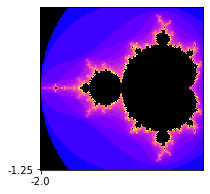

In [20]:
%time mandelbrot_image(-2.0,0.5,-1.25,1.25,maxiter=80,cmap='gnuplot2')

Wall time: 7.94 s


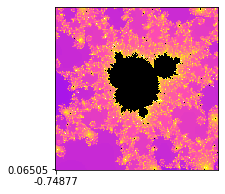

In [21]:
%time mandelbrot_image(-0.74877,-0.74872,0.06505,0.06510,maxiter=2048,cmap='gnuplot2')

## Numba

Compiling code with Numba is easy, we simply need to annotate the functions with `@jit`.

In [22]:
from numba import jit

@jit
def mandelbrot(c,maxiter):
    z = c
    for n in range(maxiter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return 0

@jit
def mandelbrot_set(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)
    n3 = np.empty((width,height))
    for i in range(width):
        for j in range(height):
            n3[i,j] = mandelbrot(r1[i] + 1j*r2[j],maxiter)
    return (r1,r2,n3)

Timing it shows it is pretty fast

In [23]:
%time mandelbrot_set(-2.0,0.5,-1.25,1.25,1000,1000,80)

Wall time: 595 ms


(array([-2.00000000e+00, -1.99749750e+00, -1.99499499e+00, -1.99249249e+00,
        -1.98998999e+00, -1.98748749e+00, -1.98498498e+00, -1.98248248e+00,
        -1.97997998e+00, -1.97747748e+00, -1.97497497e+00, -1.97247247e+00,
        -1.96996997e+00, -1.96746747e+00, -1.96496496e+00, -1.96246246e+00,
        -1.95995996e+00, -1.95745746e+00, -1.95495495e+00, -1.95245245e+00,
        -1.94994995e+00, -1.94744745e+00, -1.94494494e+00, -1.94244244e+00,
        -1.93993994e+00, -1.93743744e+00, -1.93493493e+00, -1.93243243e+00,
        -1.92992993e+00, -1.92742743e+00, -1.92492492e+00, -1.92242242e+00,
        -1.91991992e+00, -1.91741742e+00, -1.91491491e+00, -1.91241241e+00,
        -1.90990991e+00, -1.90740741e+00, -1.90490490e+00, -1.90240240e+00,
        -1.89989990e+00, -1.89739740e+00, -1.89489489e+00, -1.89239239e+00,
        -1.88988989e+00, -1.88738739e+00, -1.88488488e+00, -1.88238238e+00,
        -1.87987988e+00, -1.87737738e+00, -1.87487487e+00, -1.87237237e+00,
        -1.8

Checking if it is correct

Wall time: 18 ms


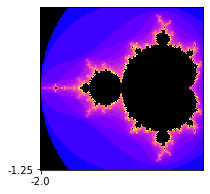

In [24]:
%time mandelbrot_image(-2.0,0.5,-1.25,1.25,cmap='gnuplot2')

Removing square root computation within abs

In [25]:
@jit
def mandelbrot(c,maxiter):
    z = c
    for n in range(maxiter):
        if z.real * z.real + z.imag * z.imag > 4.0:
            return n
        z = z*z + c
    return 0

@jit
def mandelbrot_set(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)
    n3 = np.empty((width,height))
    for i in range(width):
        for j in range(height):
            n3[i,j] = mandelbrot(r1[i] + 1j*r2[j],maxiter)
    return (r1,r2,n3)

It is faster.

In [26]:
%time mandelbrot_set(-2.0,0.5,-1.25,1.25,1000,1000,80)

Wall time: 226 ms


(array([-2.00000000e+00, -1.99749750e+00, -1.99499499e+00, -1.99249249e+00,
        -1.98998999e+00, -1.98748749e+00, -1.98498498e+00, -1.98248248e+00,
        -1.97997998e+00, -1.97747748e+00, -1.97497497e+00, -1.97247247e+00,
        -1.96996997e+00, -1.96746747e+00, -1.96496496e+00, -1.96246246e+00,
        -1.95995996e+00, -1.95745746e+00, -1.95495495e+00, -1.95245245e+00,
        -1.94994995e+00, -1.94744745e+00, -1.94494494e+00, -1.94244244e+00,
        -1.93993994e+00, -1.93743744e+00, -1.93493493e+00, -1.93243243e+00,
        -1.92992993e+00, -1.92742743e+00, -1.92492492e+00, -1.92242242e+00,
        -1.91991992e+00, -1.91741742e+00, -1.91491491e+00, -1.91241241e+00,
        -1.90990991e+00, -1.90740741e+00, -1.90490490e+00, -1.90240240e+00,
        -1.89989990e+00, -1.89739740e+00, -1.89489489e+00, -1.89239239e+00,
        -1.88988989e+00, -1.88738739e+00, -1.88488488e+00, -1.88238238e+00,
        -1.87987988e+00, -1.87737738e+00, -1.87487487e+00, -1.87237237e+00,
        -1.8

Checking if it is correct

Wall time: 13.5 ms


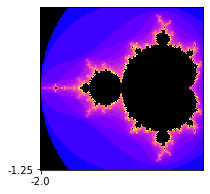

In [27]:
%time mandelbrot_image(-2.0,0.5,-1.25,1.25,cmap='gnuplot2')

Decomposing complex into two floats.

In [31]:
@jit
def mandelbrot(creal,cimag,maxiter):
    real = creal
    imag = cimag
    for n in range(maxiter):
        real2 = real*real
        imag2 = imag*imag
        if real2 + imag2 > 4.0:
            return n
        imag = 2* real*imag + cimag
        real = real2 - imag2 + creal       
    return 0


@jit
def mandelbrot_set(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)
    n3 = np.empty((width,height))
    for i in range(width):
        for j in range(height):
            n3[i,j] = mandelbrot(r1[i],r2[j],maxiter)
    return (r1,r2,n3)

Slightly faster.

In [32]:
%time mandelbrot_set(-2.0,0.5,-1.25,1.25,1000,1000,80)

Wall time: 221 ms


(array([-2.00000000e+00, -1.99749750e+00, -1.99499499e+00, -1.99249249e+00,
        -1.98998999e+00, -1.98748749e+00, -1.98498498e+00, -1.98248248e+00,
        -1.97997998e+00, -1.97747748e+00, -1.97497497e+00, -1.97247247e+00,
        -1.96996997e+00, -1.96746747e+00, -1.96496496e+00, -1.96246246e+00,
        -1.95995996e+00, -1.95745746e+00, -1.95495495e+00, -1.95245245e+00,
        -1.94994995e+00, -1.94744745e+00, -1.94494494e+00, -1.94244244e+00,
        -1.93993994e+00, -1.93743744e+00, -1.93493493e+00, -1.93243243e+00,
        -1.92992993e+00, -1.92742743e+00, -1.92492492e+00, -1.92242242e+00,
        -1.91991992e+00, -1.91741742e+00, -1.91491491e+00, -1.91241241e+00,
        -1.90990991e+00, -1.90740741e+00, -1.90490490e+00, -1.90240240e+00,
        -1.89989990e+00, -1.89739740e+00, -1.89489489e+00, -1.89239239e+00,
        -1.88988989e+00, -1.88738739e+00, -1.88488488e+00, -1.88238238e+00,
        -1.87987988e+00, -1.87737738e+00, -1.87487487e+00, -1.87237237e+00,
        -1.8

Wall time: 14 ms


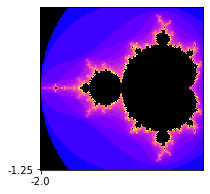

In [33]:
%time mandelbrot_image(-2.0,0.5,-1.25,1.25,cmap='gnuplot2')

Code from http://numba.pydata.org/numba-doc/0.21.0/user/examples.html

In [34]:
@jit
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    c = complex(x,y)
    z = 0j
    for i in range(max_iters):
        z = z*z + c
        if z.real * z.real + z.imag * z.imag > 4:
            return i

    return 0

@jit(nopython=True)
def create_fractal(min_x, max_x, min_y, max_y, width, height, iters):
    image = np.empty((width,height))
    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image


A tad slower than mine.

In [36]:
%time img=create_fractal(-2.0,0.5,-1.25,1.25,1000,1000,80)

Wall time: 74.8 ms


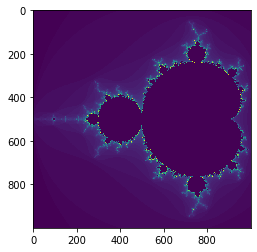

In [37]:
plt.imshow(img)

## Cython

In [38]:
%load_ext cython

In [39]:
%%cython
import cython
import numpy as np

cdef int mandelbrot(double creal, double cimag, int maxiter):
    cdef:
        double real2, imag2
        double real = creal, imag = cimag
        int n

    for n in range(maxiter):
        real2 = real*real
        imag2 = imag*imag
        if real2 + imag2 > 4.0:
            return n
        imag = 2* real*imag + cimag
        real = real2 - imag2 + creal;
    return 0

@cython.boundscheck(False) 
@cython.wraparound(False)
cpdef mandelbrot_set(double xmin, double xmax, double ymin, double ymax, int width, int height, int maxiter):
    cdef:
        double[:] r1 = np.linspace(xmin, xmax, width)
        double[:] r2 = np.linspace(ymin, ymax, height)
        int[:,:] n3 = np.empty((width,height), np.int)
        int i,j
    
    for i in range(width):
        for j in range(height):
            n3[i,j] = mandelbrot(r1[i], r2[j], maxiter)
     
    return (r1,r2,n3)

Almost as fast as Numba

In [40]:
%time mandelbrot_set(-2.0,0.5,-1.25,1.25,1000,1000,80)

Wall time: 78.8 ms


(<MemoryView of 'ndarray' at 0x2a7301988b8>,
 <MemoryView of 'ndarray' at 0x2a730198a68>,
 <MemoryView of 'ndarray' at 0x2a730198c18>)

In [25]:
%time mandelbrot_set(-0.74877,-0.74872,0.06505,0.06510,1000,1000,2048)

1 loops, best of 3: 2.8 s per loop


Let's check it

Wall time: 14.8 ms


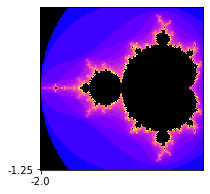

In [41]:
%time mandelbrot_image(-2.0,0.5,-1.25,1.25,cmap='gnuplot2')

## Numpy array operations

Code from https://github.com/pyopencl/pyopencl/blob/master/examples/demo_mandelbrot.py

In [42]:
def mandelbrot_numpy(q, maxiter):
    # calculate z using numpy, this is the original
    # routine from vegaseat's URL
    output = np.resize(np.array(0,), q.shape)
    z = np.zeros(q.shape, np.complex64)
    for it in range(maxiter):
        z = z*z + q
        done = np.greater(abs(z), 2.0)
        q = np.where(done, 0+0j, q)
        z = np.where(done, 0+0j, z)
        output = np.where(done, it, output)
    return output

def mandelbrot_set(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)
    q = np.ravel(r1 + r2[:,None]*1j)
    n3 = mandelbrot_numpy(q,maxiter)
    n3 = n3.reshape((width,height))
    return (r1,r2,n3.T)

In [43]:
%time mandelbrot_set(-2.0,0.5,-1.25,1.25,1000,1000,80)

Wall time: 2.19 s


(array([-2.00000000e+00, -1.99749750e+00, -1.99499499e+00, -1.99249249e+00,
        -1.98998999e+00, -1.98748749e+00, -1.98498498e+00, -1.98248248e+00,
        -1.97997998e+00, -1.97747748e+00, -1.97497497e+00, -1.97247247e+00,
        -1.96996997e+00, -1.96746747e+00, -1.96496496e+00, -1.96246246e+00,
        -1.95995996e+00, -1.95745746e+00, -1.95495495e+00, -1.95245245e+00,
        -1.94994995e+00, -1.94744745e+00, -1.94494494e+00, -1.94244244e+00,
        -1.93993994e+00, -1.93743744e+00, -1.93493493e+00, -1.93243243e+00,
        -1.92992993e+00, -1.92742743e+00, -1.92492492e+00, -1.92242242e+00,
        -1.91991992e+00, -1.91741742e+00, -1.91491491e+00, -1.91241241e+00,
        -1.90990991e+00, -1.90740741e+00, -1.90490490e+00, -1.90240240e+00,
        -1.89989990e+00, -1.89739740e+00, -1.89489489e+00, -1.89239239e+00,
        -1.88988989e+00, -1.88738739e+00, -1.88488488e+00, -1.88238238e+00,
        -1.87987988e+00, -1.87737738e+00, -1.87487487e+00, -1.87237237e+00,
        -1.8

We can check it is correct with the following.

Wall time: 51 ms


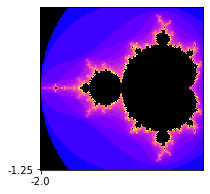

In [44]:
%time mandelbrot_image(-2.0,0.5,-1.25,1.25,cmap='gnuplot2')

There is a better code from http://www.vallis.org/salon/summary-10.html

In [45]:
def mandelbrot_numpy(c, maxiter):
    output = np.zeros(c.shape)
    z = np.empty(c.shape, np.complex64)
    output[:] = maxiter
    for it in range(maxiter):
        notdone = (output == maxiter)
        z[notdone] = z[notdone]**2 + c[notdone]
        output[notdone & (z.real*z.real + z.imag*z.imag > 4.0)] = it
        
    return output

It is indeed way faster.

In [46]:
%time mandelbrot_set(-2.0,0.5,-1.25,1.25,1000,1000,80)

Wall time: 939 ms


(array([-2.00000000e+00, -1.99749750e+00, -1.99499499e+00, -1.99249249e+00,
        -1.98998999e+00, -1.98748749e+00, -1.98498498e+00, -1.98248248e+00,
        -1.97997998e+00, -1.97747748e+00, -1.97497497e+00, -1.97247247e+00,
        -1.96996997e+00, -1.96746747e+00, -1.96496496e+00, -1.96246246e+00,
        -1.95995996e+00, -1.95745746e+00, -1.95495495e+00, -1.95245245e+00,
        -1.94994995e+00, -1.94744745e+00, -1.94494494e+00, -1.94244244e+00,
        -1.93993994e+00, -1.93743744e+00, -1.93493493e+00, -1.93243243e+00,
        -1.92992993e+00, -1.92742743e+00, -1.92492492e+00, -1.92242242e+00,
        -1.91991992e+00, -1.91741742e+00, -1.91491491e+00, -1.91241241e+00,
        -1.90990991e+00, -1.90740741e+00, -1.90490490e+00, -1.90240240e+00,
        -1.89989990e+00, -1.89739740e+00, -1.89489489e+00, -1.89239239e+00,
        -1.88988989e+00, -1.88738739e+00, -1.88488488e+00, -1.88238238e+00,
        -1.87987988e+00, -1.87737738e+00, -1.87487487e+00, -1.87237237e+00,
        -1.8

The code can be made faster by only performing computation where needed. There is no need to ravel the input array either.

In [47]:
def mandelbrot_numpy(c, maxiter):
    output = np.zeros(c.shape)
    z = np.zeros(c.shape, np.complex64)
    for it in range(maxiter):
        notdone = np.less(z.real*z.real + z.imag*z.imag, 4.0)
        output[notdone] = it
        z[notdone] = z[notdone]**2 + c[notdone]
    output[output == maxiter-1] = 0
    return output

def mandelbrot_set(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width, dtype=np.float32)
    r2 = np.linspace(ymin, ymax, height, dtype=np.float32)
    c = r1 + r2[:,None]*1j
    n3 = mandelbrot_numpy(c,maxiter)
    return (r1,r2,n3.T) 

It is about 3 times faster than the first Numpy array code.

In [48]:
%time mandelbrot_set(-2.0,0.5,-1.25,1.25,1000,1000,80)

Wall time: 746 ms


(array([-2.00000000e+00, -1.99749744e+00, -1.99499500e+00, -1.99249244e+00,
        -1.98999000e+00, -1.98748744e+00, -1.98498499e+00, -1.98248243e+00,
        -1.97997999e+00, -1.97747743e+00, -1.97497499e+00, -1.97247243e+00,
        -1.96996999e+00, -1.96746743e+00, -1.96496499e+00, -1.96246243e+00,
        -1.95995998e+00, -1.95745742e+00, -1.95495498e+00, -1.95245242e+00,
        -1.94994998e+00, -1.94744742e+00, -1.94494498e+00, -1.94244242e+00,
        -1.93993998e+00, -1.93743742e+00, -1.93493497e+00, -1.93243241e+00,
        -1.92992997e+00, -1.92742741e+00, -1.92492497e+00, -1.92242241e+00,
        -1.91991997e+00, -1.91741741e+00, -1.91491497e+00, -1.91241241e+00,
        -1.90990996e+00, -1.90740740e+00, -1.90490496e+00, -1.90240240e+00,
        -1.89989984e+00, -1.89739740e+00, -1.89489484e+00, -1.89239240e+00,
        -1.88988984e+00, -1.88738739e+00, -1.88488483e+00, -1.88238239e+00,
        -1.87987983e+00, -1.87737739e+00, -1.87487483e+00, -1.87237239e+00,
        -1.8

We can check it is correct with the following.

Wall time: 27.9 ms


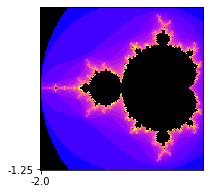

In [49]:
%time mandelbrot_image(-2.0,0.5,-1.25,1.25,cmap='gnuplot2')

## Numexpr

We can avoid temporary array creation with NumExpr.

In [50]:
import numexpr as ne

def mandelbrot_numpy(c, maxiter):
    output = np.zeros(c.shape)
    z = np.zeros(c.shape, np.complex64)
    for it in range(maxiter):
        notdone = ne.evaluate('z.real*z.real + z.imag*z.imag < 4.0')
        output[notdone] = it
        z = ne.evaluate('where(notdone,z**2+c,z)')
    output[output == maxiter-1] = 0    
    return output

This is faster.

In [51]:
%time mandelbrot_set(-2.0,0.5,-1.25,1.25,1000,1000,80)

Wall time: 373 ms


(array([-2.00000000e+00, -1.99749744e+00, -1.99499500e+00, -1.99249244e+00,
        -1.98999000e+00, -1.98748744e+00, -1.98498499e+00, -1.98248243e+00,
        -1.97997999e+00, -1.97747743e+00, -1.97497499e+00, -1.97247243e+00,
        -1.96996999e+00, -1.96746743e+00, -1.96496499e+00, -1.96246243e+00,
        -1.95995998e+00, -1.95745742e+00, -1.95495498e+00, -1.95245242e+00,
        -1.94994998e+00, -1.94744742e+00, -1.94494498e+00, -1.94244242e+00,
        -1.93993998e+00, -1.93743742e+00, -1.93493497e+00, -1.93243241e+00,
        -1.92992997e+00, -1.92742741e+00, -1.92492497e+00, -1.92242241e+00,
        -1.91991997e+00, -1.91741741e+00, -1.91491497e+00, -1.91241241e+00,
        -1.90990996e+00, -1.90740740e+00, -1.90490496e+00, -1.90240240e+00,
        -1.89989984e+00, -1.89739740e+00, -1.89489484e+00, -1.89239240e+00,
        -1.88988984e+00, -1.88738739e+00, -1.88488483e+00, -1.88238239e+00,
        -1.87987983e+00, -1.87737739e+00, -1.87487483e+00, -1.87237239e+00,
        -1.8

Check.

Wall time: 85.8 ms


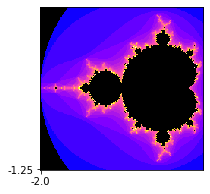

In [52]:
%time mandelbrot_image(-2.0,0.5,-1.25,1.25,cmap='gnuplot2')

## Numba vectorize

An alternative to NumExpr.

In [53]:
from numba import vectorize, complex64, boolean, jit

@vectorize([boolean(complex64)])
def f(z):
    return (z.real*z.real + z.imag*z.imag) < 4.0

@vectorize([complex64(complex64, complex64)])
def g(z,c):
    return z*z + c 

@jit
def mandelbrot_numpy(c, maxiter):
    output = np.zeros(c.shape, np.int)
    z = np.empty(c.shape, np.complex64)
    for it in range(maxiter):
        notdone = f(z)
        output[notdone] = it
        z[notdone] = g(z[notdone],c[notdone]) 
    output[output == maxiter-1] = 0
    return output


def mandelbrot_set(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width, dtype=np.float32)
    r2 = np.linspace(ymin, ymax, height, dtype=np.float32)
    c = np.empty((r1.shape[0], r2.shape[0]), dtype=np.complex64)
    c[:,:] = r1 + r2[:,None]*1j
    n3 = mandelbrot_numpy(c,maxiter)
    return (r1,r2,n3.T) 

Even faster!

In [54]:
%time mandelbrot_set(-2.0,0.5,-1.25,1.25,1000,1000,80)

<ipython-input-53-46d2ca0686a3>:11: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "mandelbrot_numpy" failed type inference due to: Invalid use of Function(<built-in function zeros>) with argument(s) of type(s): (tuple(int64 x 2), Function(<class 'int'>))
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<built-in function zeros>)
[2] During: typing of call at <ipython-input-53-46d2ca0686a3> (13)


File "<ipython-input-53-46d2ca0686a3>", line 13:
def mandelbrot_numpy(c, maxiter):
    output = np.zeros(c.shape, np.int)
    ^

  @jit
<ipython-input-53-46d2ca0686a3>:11: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "mandelbrot_numpy" failed type in

Wall time: 762 ms


(array([-2.00000000e+00, -1.99749744e+00, -1.99499500e+00, -1.99249244e+00,
        -1.98999000e+00, -1.98748744e+00, -1.98498499e+00, -1.98248243e+00,
        -1.97997999e+00, -1.97747743e+00, -1.97497499e+00, -1.97247243e+00,
        -1.96996999e+00, -1.96746743e+00, -1.96496499e+00, -1.96246243e+00,
        -1.95995998e+00, -1.95745742e+00, -1.95495498e+00, -1.95245242e+00,
        -1.94994998e+00, -1.94744742e+00, -1.94494498e+00, -1.94244242e+00,
        -1.93993998e+00, -1.93743742e+00, -1.93493497e+00, -1.93243241e+00,
        -1.92992997e+00, -1.92742741e+00, -1.92492497e+00, -1.92242241e+00,
        -1.91991997e+00, -1.91741741e+00, -1.91491497e+00, -1.91241241e+00,
        -1.90990996e+00, -1.90740740e+00, -1.90490496e+00, -1.90240240e+00,
        -1.89989984e+00, -1.89739740e+00, -1.89489484e+00, -1.89239240e+00,
        -1.88988984e+00, -1.88738739e+00, -1.88488483e+00, -1.88238239e+00,
        -1.87987983e+00, -1.87737739e+00, -1.87487483e+00, -1.87237239e+00,
        -1.8

Check.

Wall time: 27 ms


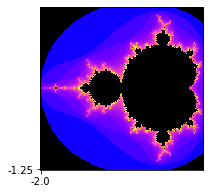

In [55]:
%time mandelbrot_image(-2.0,0.5,-1.25,1.25,cmap='gnuplot2')

Try parallelism

In [44]:
from numba import vectorize, complex64, boolean

@vectorize([boolean(complex64)], target='parallel')
def f(z):
    return (z.real*z.real + z.imag*z.imag) < 4.0

@vectorize([complex64(complex64, complex64)], target='parallel')
def g(z,c):
    return z*z + c 

def mandelbrot_numpy(c, maxiter):
    output = np.empty(c.shape, np.int)
    z = np.zeros(c.shape, np.complex64)
    for it in range(maxiter):
        notdone = f(z)
        output[notdone] = it
        z[notdone] = g(z[notdone],c[notdone])   
    return output

Not paying off.

In [45]:
%time mandelbrot_set2(-2.0,0.5,-1.25,1.25,1000,1000,80)

1 loops, best of 3: 793 ms per loop


In [46]:
%time mandelbrot_set2(-0.74877,-0.74872,0.06505,0.06510,1000,1000,2048)

1 loops, best of 3: 27.3 s per loop


We should parallelize the top loop.  We can do it via guvectorize.

## Numba Guvectorize

Let's try guvectorize too.  It amounts to reusing the sequential code.

In [56]:
import numpy as np
from numba import jit, vectorize, guvectorize, float64, complex64, int32, float32

@jit(int32(complex64, int32))
def mandelbrot(c,maxiter):
    nreal = 0
    real = 0
    imag = 0
    for n in range(maxiter):
        nreal = real*real - imag*imag + c.real
        imag = 2* real*imag + c.imag
        real = nreal;
        if real * real + imag * imag > 4.0:
            return n
    return 0

@guvectorize([(complex64[:], int32[:], int32[:])], '(n),()->(n)',target='parallel')
def mandelbrot_numpy(c, maxit, output):
    maxiter = maxit[0]
    for i in range(c.shape[0]):
        output[i] = mandelbrot(c[i],maxiter)
        
def mandelbrot_set(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width, dtype=np.float32)
    r2 = np.linspace(ymin, ymax, height, dtype=np.float32)
    c = r1 + r2[:,None]*1j
    n3 = mandelbrot_numpy(c,maxiter)
    return (r1,r2,n3.T) 

Way faster than the sequential code compiled with Numba. 

In [57]:
%time mandelbrot_set(-2.0,0.5,-1.25,1.25,1000,1000,80)

Wall time: 17 ms


(array([-2.00000000e+00, -1.99749744e+00, -1.99499500e+00, -1.99249244e+00,
        -1.98999000e+00, -1.98748744e+00, -1.98498499e+00, -1.98248243e+00,
        -1.97997999e+00, -1.97747743e+00, -1.97497499e+00, -1.97247243e+00,
        -1.96996999e+00, -1.96746743e+00, -1.96496499e+00, -1.96246243e+00,
        -1.95995998e+00, -1.95745742e+00, -1.95495498e+00, -1.95245242e+00,
        -1.94994998e+00, -1.94744742e+00, -1.94494498e+00, -1.94244242e+00,
        -1.93993998e+00, -1.93743742e+00, -1.93493497e+00, -1.93243241e+00,
        -1.92992997e+00, -1.92742741e+00, -1.92492497e+00, -1.92242241e+00,
        -1.91991997e+00, -1.91741741e+00, -1.91491497e+00, -1.91241241e+00,
        -1.90990996e+00, -1.90740740e+00, -1.90490496e+00, -1.90240240e+00,
        -1.89989984e+00, -1.89739740e+00, -1.89489484e+00, -1.89239240e+00,
        -1.88988984e+00, -1.88738739e+00, -1.88488483e+00, -1.88238239e+00,
        -1.87987983e+00, -1.87737739e+00, -1.87487483e+00, -1.87237239e+00,
        -1.8

Check

Wall time: 11.1 ms


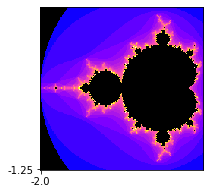

In [58]:
%time mandelbrot_image(-2.0,0.5,-1.25,1.25,cmap='gnuplot2')

Let's try Cuda target.  Since there is a bug, we must pass the iteration max as an array too.

`$ conda install cudatoolkit`

In [8]:
import numpy as np
from numba import jit, vectorize, guvectorize, float64, complex64, int32, float32

@jit(int32(complex64, int32))
def mandelbrot(c,maxiter):
    creal = c.real
    cimag = c.imag
    real = creal
    imag = cimag
    for n in range(maxiter):
        real2 = real*real
        imag2 = imag*imag
        if real2 + imag2 > 4.0:
            return n
        imag = 2* real*imag + cimag
        real = real2 - imag2 + creal
        
    return 0

@guvectorize([(complex64[:], int32[:], int32[:])], '(n),(n)->(n)', target='cuda')
def mandelbrot_numpy(c, maxit, output):
    maxiter = maxit[0]
    for i in range(c.shape[0]):
        creal = c[i].real
        cimag = c[i].imag
        real = creal
        imag = cimag
        output[i] = 0
        for n in range(maxiter):
            real2 = real*real
            imag2 = imag*imag
            if real2 + imag2 > 4.0:
                output[i] = n
                break
            imag = 2* real*imag + cimag
            real = real2 - imag2 + creal
            
        
def mandelbrot_set(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width, dtype=np.float32)
    r2 = np.linspace(ymin, ymax, height, dtype=np.float32)
    c = r1 + r2[:,None]*1j
    n3 = np.empty(c.shape, int)
    maxit = np.ones(c.shape, int) * maxiter
    n3 = mandelbrot_numpy(c,maxit)
    return (r1,r2,n3.T) 

Slightly slower.

In [9]:
%time mandelbrot_set(-2.0,0.5,-1.25,1.25,1000,1000,80)

Wall time: 54.9 ms


(array([-2.00000000e+00, -1.99749744e+00, -1.99499500e+00, -1.99249244e+00,
        -1.98999000e+00, -1.98748744e+00, -1.98498499e+00, -1.98248243e+00,
        -1.97997999e+00, -1.97747743e+00, -1.97497499e+00, -1.97247243e+00,
        -1.96996999e+00, -1.96746743e+00, -1.96496499e+00, -1.96246243e+00,
        -1.95995998e+00, -1.95745742e+00, -1.95495498e+00, -1.95245242e+00,
        -1.94994998e+00, -1.94744742e+00, -1.94494498e+00, -1.94244242e+00,
        -1.93993998e+00, -1.93743742e+00, -1.93493497e+00, -1.93243241e+00,
        -1.92992997e+00, -1.92742741e+00, -1.92492497e+00, -1.92242241e+00,
        -1.91991997e+00, -1.91741741e+00, -1.91491497e+00, -1.91241241e+00,
        -1.90990996e+00, -1.90740740e+00, -1.90490496e+00, -1.90240240e+00,
        -1.89989984e+00, -1.89739740e+00, -1.89489484e+00, -1.89239240e+00,
        -1.88988984e+00, -1.88738739e+00, -1.88488483e+00, -1.88238239e+00,
        -1.87987983e+00, -1.87737739e+00, -1.87487483e+00, -1.87237239e+00,
        -1.8

Check

Wall time: 14.1 ms


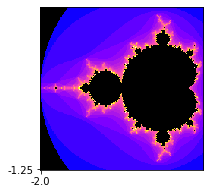

In [10]:
%time mandelbrot_image(-2.0,0.5,-1.25,1.25,cmap='gnuplot2')

## TensorFlow

Code from https://www.tensorflow.org/versions/master/tutorials/mandelbrot/index.html

Timings on my machine:

5.29394221306

34.6283330917

## PyOpenCl

We reuse the boilerplate code from PyOpenCl documentation as much as possible.

In [55]:
from __future__ import absolute_import
from __future__ import print_function

import pyopencl as cl

failed to `pip install pyopencl` on windows, ok on WSL

In [56]:
%load_ext pyopencl.ipython_ext

We create a context interactively in order to select which device to use.

In [57]:
ctx = cl.create_some_context(interactive=True)
devices = ctx.get_info(cl.context_info.DEVICES)
print(devices)

[<pyopencl.Device 'Intel(R) Core(TM) i7-2760QM CPU @ 2.40GHz' on 'Intel(R) OpenCL' at 0x407ca20>]


The code is moving the heavy duty piece to a piece of C code thta gets compiled and run on the selected device.

Input and output for that code is handled in Python.

In [58]:
def mandelbrot_gpu(q, maxiter):

    global ctx
    
    queue = cl.CommandQueue(ctx)
    
    output = np.empty(q.shape, dtype=np.uint16)

    prg = cl.Program(ctx, """
    #pragma OPENCL EXTENSION cl_khr_byte_addressable_store : enable
    __kernel void mandelbrot(__global float2 *q,
                     __global ushort *output, ushort const maxiter)
    {
        int gid = get_global_id(0);
        float nreal, real = 0;
        float imag = 0;
        output[gid] = 0;
        for(int curiter = 0; curiter < maxiter; curiter++) {
            nreal = real*real - imag*imag + q[gid].x;
            imag = 2* real*imag + q[gid].y;
            real = nreal;
            if (real*real + imag*imag > 4.0f){
                 output[gid] = curiter;
                 break;
            }
        }
    }
    """).build()

    mf = cl.mem_flags
    q_opencl = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=q)
    output_opencl = cl.Buffer(ctx, mf.WRITE_ONLY, output.nbytes)


    prg.mandelbrot(queue, output.shape, None, q_opencl,
                   output_opencl, np.uint16(maxiter))

    cl.enqueue_copy(queue, output, output_opencl).wait()
    
    return output

def mandelbrot_set(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width, dtype=np.float32)
    r2 = np.linspace(ymin, ymax, height, dtype=np.float32)
    c = r1 + r2[:,None]*1j
    c = np.ravel(c)
    n3 = mandelbrot_gpu(c,maxiter)
    n3 = n3.reshape((width,height))
    return (r1,r2,n3.T)

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\pyopencl\__init__.py:206: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


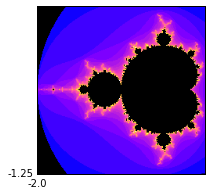

In [60]:
%time mandelbrot_image(-2.0,0.5,-1.25,1.25,cmap='gnuplot2')

Following code is faster on gpu, above code is faster on cpu.

In [11]:
def mandelbrot_gpu(q, maxiter):

    global ctx
    
    queue = cl.CommandQueue(ctx)
    
    output = np.empty(q.shape, dtype=np.uint16)

    prg = cl.Program(ctx, """
    #pragma OPENCL EXTENSION cl_khr_byte_addressable_store : enable
    __kernel void mandelbrot(__global float2 *q,
                     __global ushort *output, ushort const maxiter)
    {
        int gid = get_global_id(0);
        float real = q[gid].x;
        float imag = q[gid].y;
        output[gid] = 0;
        for(int curiter = 0; curiter < maxiter; curiter++) {
            float real2 = real*real, imag2 = imag*imag;
            if (real*real + imag*imag > 4.0f){
                 output[gid] = curiter;
                 return;
            }
            imag = 2* real*imag + q[gid].y;
            real = real2 - imag2 + q[gid].x;
            
        }
    }
    """).build()

    mf = cl.mem_flags
    q_opencl = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=q)
    output_opencl = cl.Buffer(ctx, mf.WRITE_ONLY, output.nbytes)


    prg.mandelbrot(queue, output.shape, None, q_opencl,
                   output_opencl, np.uint16(maxiter))

    cl.enqueue_copy(queue, output, output_opencl).wait()
    
    return output

def mandelbrot_set(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width, dtype=np.float32)
    r2 = np.linspace(ymin, ymax, height, dtype=np.float32)
    c = r1 + r2[:,None]*1j
    c = np.ravel(c)
    n3 = mandelbrot_gpu(c,maxiter)
    n3 = n3.reshape((width,height))
    return (r1,r2,n3.T)

This is way faster than the rest

Let's check it is correct

In [12]:
%time mandelbrot_image(-2.0,0.5,-1.25,1.25,cmap='gnuplot2')

NameError: name 'cl' is not defined

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\pyopencl\__init__.py:206: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


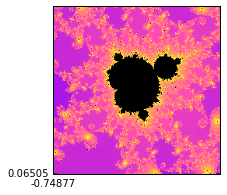

In [61]:
%time mandelbrot_image(-0.74877,-0.74872,0.06505,0.06510,maxiter=2048,cmap='gnuplot2')

In [ ]:
%time mandelbrot_set3(-2.0,0.5,-1.25,1.25,1000,1000,80)

In [62]:
%time mandelbrot_set3(-0.74877,-0.74872,0.06505,0.06510,1000,1000,2048)

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\pyopencl\__init__.py:206: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)
C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\pyopencl\__init__.py:206: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


10 loops, best of 3: 20.6 ms per loop
10 loops, best of 3: 173 ms per loop


## PyCUDA

Modified from http://wiki.tiker.net/PyCuda/Examples/Mandelbrot

In [6]:
import pycuda.driver as drv
import pycuda.tools
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.gpuarray as gpuarray
from pycuda.elementwise import ElementwiseKernel

complex_gpu1 = ElementwiseKernel(
    "pycuda::complex<float> *q, int *output, int maxiter",
    """
    {
        float nreal, real = 0;
        float imag = 0;
        output[i] = 0;
        for(int curiter = 0; curiter < maxiter; curiter++) {
            nreal = real*real - imag*imag + q[i].real();
            imag = 2* real*imag + q[i].imag();
            real = nreal;
            if (real*real + imag*imag > 4.0f){
                output[i] = curiter;
                break;
                };
        };
    }
    """,
    "complex5",
    preamble="#include <pycuda-complex.hpp>",)

complex_gpu = ElementwiseKernel(
    "pycuda::complex<float> *q, int *output, int maxiter",
    """
    {
        float nreal, real = 0;
        float imag = 0;
        output[i] = 0;
        for(int curiter = 0; curiter < maxiter; curiter++) {
            float real2 = real*real;
            float imag2 = imag*imag;
            nreal = real2 - imag2 + q[i].real();
            imag = 2* real*imag + q[i].imag();
            real = nreal;
            if (real2 + imag2 > 4.0f){
                output[i] = curiter;
                break;
                };
        };
    }
    """,
    "complex5",
    preamble="#include <pycuda-complex.hpp>",)

complex_gpu1 = ElementwiseKernel(
    "pycuda::complex<float> *q, int *output, int maxiter",
    """
    {
        float real = q[i].real();
        float imag = q[i].imag();
        output[i] = 0;
        for(int curiter = 0; curiter < maxiter; curiter++) {
            float real2 = real*real;
            float imag2 = imag*imag;
            if (real2 + imag2 > 4.0f){
                output[i] = curiter;
                break;
            };
            imag = 2* real*imag + q[i].imag();
            real = real2 - imag2 + q[i].real();
         };
    }
    """,
    "complex5",
    preamble="#include <pycuda-complex.hpp>",)

def mandelbrot_gpu(c, maxiter):
    q_gpu = gpuarray.to_gpu(c.astype(np.complex64))
    iterations_gpu = gpuarray.to_gpu(np.empty(c.shape, dtype=np.int))
    complex_gpu(q_gpu, iterations_gpu, maxiter)

    return iterations_gpu.get()

def mandelbrot_set(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width, dtype=np.float32)
    r2 = np.linspace(ymin, ymax, height, dtype=np.float32)
    c = r1 + r2[:,None]*1j
    c = np.ravel(c)
    n3 = mandelbrot_gpu(c,maxiter)
    n3 = n3.reshape((width,height))
    return (r1,r2,n3.T)

Let's check it is correct

In [7]:
%time mandelbrot_image(-2.0,0.5,-1.25,1.25,cmap='gnuplot2')

CompileError: nvcc preprocessing of C:\Users\19196\AppData\Local\Temp\tmp6c3mk0kh.cu failed
[command: nvcc --preprocess -arch sm_61 -m64 -Ic:\users\19196\anaconda3\lib\site-packages\pycuda\cuda C:\Users\19196\AppData\Local\Temp\tmp6c3mk0kh.cu --compiler-options -EP]

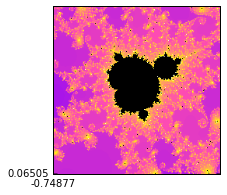

In [65]:
%time mandelbrot_image(-0.74877,-0.74872,0.06505,0.06510,maxiter=2048,cmap='gnuplot2')

In [66]:
%time mandelbrot_set3(-2.0,0.5,-1.25,1.25,1000,1000,80)

10 loops, best of 3: 31.9 ms per loop


In [67]:
%time mandelbrot_set3(-0.74877,-0.74872,0.06505,0.06510,1000,1000,2048)

1 loops, best of 3: 193 ms per loop


## Number of iterations

Total running time isn't the only way to look at results. Time per iteration is also interesting. We have two flavors of code, those who loop first on pixels, then on iteration of complex computation, and those who loop first on the complex iteration using array operations.  The average number of iteration is way lower in the former case.  Let's compute it.

We must be careful though, as we set to 0 the pixels that did not escape horizon.  let's use a code variant that does not do this.

In [68]:
from numba import jit

@jit
def mandelbrot(creal,cimag,maxiter):
    real = creal
    imag = cimag
    for n in range(maxiter):
        real2 = real*real
        imag2 = imag*imag
        if real2 + imag2 > 4.0:
            return n
        imag = 2* real*imag + cimag
        real = real2 - imag2 + creal       
    return maxiter


@jit
def mandelbrot_set4(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)
    n3 = np.empty((width,height))
    for i in range(width):
        for j in range(height):
            n3[i,j] = mandelbrot(r1[i],r2[j],maxiter)
    return (r1,r2,n3)

In [69]:
(r1,r2,n3) = mandelbrot_set4(-2.0,0.5,-1.25,1.25,1000,1000,80)
print(n3.mean())

(r1,r2,n3) = mandelbrot_set4(-0.74877,-0.74872,0.06505,0.06510,1000,1000,2048)
print(n3.mean())

23.46311
582.160638
